Let's predict Diabetes using ```'diabetes_binary_5050split_health_indicators_BRFSS2015.csv'``` file.**

In [1]:
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

/var/folders/zx/c94b09b50v31fk6qp9h3h1cw0000gn/T/ipykernel_9331/605514168.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Set random seed and Use 'cuda' GPU
torch.manual_seed(0)

if torch.cuda.is_available():
    print("CUDA is available")
    device = 'cuda'
    torch.cuda.manual_seed_all(0) 
elif torch.backends.mps.is_available():
    print("MPS is available")
    device = torch.device("mps")
    torch.mps.manual_seed(0)
else:
    print("CUDA is not available")
    device = 'cpu'


MPS is available


In [3]:
# Get Total Dataset
df_train = pd.read_csv('Data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [4]:
df_train.shape

(70692, 22)

In [5]:
df_train.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [6]:
df_train['Diabetes_binary'].value_counts()

Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

As I can see with ```df_train.head()``` and ```df_train.info()```, it would be better to convert the values into **int**.

In [45]:
df_train = df_train.astype(int)

# Data Preparation

## Dataset Split

Train set + Validation set + Test set

In [14]:
# Dataset split
X = df_train.drop('Diabetes_binary', axis=1)
y = df_train['Diabetes_binary']

In [15]:
# Use 10 % of total data as Test set and the rest as (Train + Validation) set 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1)

# Use 20 % of (Train + Validation) set as Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

## Scaling

In [16]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [10]:
X_train.shape

(50897, 21)

## Convert into Tensor

In [17]:
X_train = torch.LongTensor(X_train).float().to(device)
X_val = torch.LongTensor(X_val).float().to(device)

y_train = torch.LongTensor(y_train.values).to(device)
y_val = torch.LongTensor(y_val.values).to(device)




# Model

In [18]:
# Hyperparameter
learning_rate = 1e-1
n_epochs = 500
drop_prob = 0.3

In [22]:
X_train.shape

torch.Size([50897, 21])

In [23]:
X_train

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [19]:
def randomize_class(a, include=True):
        # Get the number of classes and the number of samples
        num_classes = a.size(1)
        num_samples = a.size(0)

        # Generate random indices for each row to place 1s, excluding the original positions
        random_indices = torch.randint(0, num_classes, (num_samples,)).to(a.device)

        # Ensure that the generated indices are different from the original positions
        # TODO we inclue also same label to make sure that every class is represented 
        if not include:
            original_indices = a.argmax(dim=1)
            random_indices = torch.where(random_indices == original_indices, (random_indices + 1) % num_classes, random_indices)

        # Create a second tensor with 1s at the random indices
        b = torch.zeros_like(a)
        b[torch.arange(num_samples), random_indices] = 1
        return b

In [20]:
# Model
EPS = 1e-9
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(21, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 2)
        self.concept_mean_predictor = torch.nn.Sequential(torch.nn.Linear(21, 128), torch.nn.LeakyReLU(), torch.nn.Linear(128, 20))
        self.concept_var_predictor = torch.nn.Sequential(torch.nn.Linear(21, 128), torch.nn.LeakyReLU(), torch.nn.Linear(128, 20))
        self.decoder = torch.nn.Sequential(torch.nn.Linear(20, 128), torch.nn.LeakyReLU(), torch.nn.Linear(128, 21))
        self.concept_mean_z3_predictor = torch.nn.Sequential(torch.nn.Linear(20 + 21 + 2, 128), torch.nn.LeakyReLU(), torch.nn.Linear(128, 20))
        self.concept_var_z3_predictor = torch.nn.Sequential(torch.nn.Linear(20 + 21 + 2, 128), torch.nn.LeakyReLU(), torch.nn.Linear(128, 20))
        self.concept_mean_qz3_predictor = torch.nn.Sequential(torch.nn.Linear(20 + 21 + 4, 128), torch.nn.LeakyReLU(), torch.nn.Linear(128, 20))
        self.concept_var_qz3_predictor = torch.nn.Sequential(torch.nn.Linear(20 + 21 + 4, 128), torch.nn.LeakyReLU(), torch.nn.Linear(128, 20))
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        out = self.relu(out)
        
        out = self.fc5(out)
        
        z2_mu = self.concept_mean_predictor(x)
        z2_log_var = self.concept_var_predictor(x)
        z2_sigma = torch.exp(z2_log_var / 2) + EPS
        qz2_x = torch.distributions.Normal(z2_mu, z2_sigma)
        z2 = qz2_x.rsample()
        p_z2 = torch.distributions.Normal(torch.zeros_like(qz2_x.mean), torch.ones_like(qz2_x.mean))

        x_reconstructed = self.decoder(z2)
        x_reconstructed = torch.clamp(x_reconstructed, min=0, max=1)
        
        y_prime = randomize_class((out).float(), include=True)
        
        z2_c_y_y_prime = torch.cat((z2, x, out, y_prime), dim=1)
        z3_mu = self.concept_mean_qz3_predictor(z2_c_y_y_prime)
        z3_log_var = self.concept_var_qz3_predictor(z2_c_y_y_prime)
        z3_sigma = torch.exp(z3_log_var / 2) + EPS
        qz3_z2_c_y_y_prime = torch.distributions.Normal(z3_mu, z3_sigma)
        z3 = qz3_z2_c_y_y_prime.rsample(sample_shape=torch.Size())
        
        z2_c_y = torch.cat((z2, x, out), dim=1)
        z3_mu = self.concept_mean_z3_predictor(z2_c_y)
        z3_log_var = self.concept_var_z3_predictor(z2_c_y)
        z3_sigma = torch.exp(z3_log_var / 2) + EPS
        pz3_z2_c_y = torch.distributions.Normal(z3_mu, z3_sigma)
        
        x_prime_reconstructed = self.decoder(z3)
        x_prime_reconstructed = torch.clamp(x_prime_reconstructed, min=0, max=1)
        
        out2 = self.fc1(x_prime_reconstructed)
        out2 = self.relu(out2)
        
        out2 = self.fc2(out2)
        out2 = self.relu(out2)
        
        out2 = self.fc3(out2)
        out2 = self.relu(out2)
        
        out2 = self.fc4(out2)
        out2 = self.relu(out2)
        
        out2 = self.fc5(out2)
        
    
        return out, x_reconstructed, qz2_x, p_z2, out2, x_prime_reconstructed, qz3_z2_c_y_y_prime, pz3_z2_c_y, y_prime

In [21]:
model = Net().to(device)

# Optimizer and Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
mse_loss = nn.MSELoss()

# Train

Train with Validation

In [22]:
import torch.nn.functional as F
train_loss = list()
val_loss = list()

for epoch in range(1, n_epochs+1):
    model.train()
    H, x_reconstructed, q, p, H2, x_prime, q_prime, p_prime, y_prime = model(X_train)
    loss_task = loss_fn(H, y_train)
    loss_kl = torch.distributions.kl_divergence(p, q).mean()
    loss_rec = F.mse_loss(x_reconstructed, X_train, reduction='mean')
    loss_validity = loss_fn(H2, y_prime.argmax(dim=-1))
    loss_kl2 = torch.distributions.kl_divergence(p_prime, q_prime).mean() 
    loss_p_d = torch.distributions.kl_divergence(p, p_prime).mean() 
    
    loss = loss_task + 0.1*loss_kl + 10*loss_rec + 0.5*loss_validity + 0.1*loss_kl + loss_p_d
    print(loss_task, loss_kl, loss_rec, loss_validity)
    train_loss.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = (torch.argmax(H, dim=1) == y_train).float().mean().item()
    acc_prime = (torch.argmax(H2, dim=1) == y_prime.argmax(dim=-1)).float().mean().item()
    
    model.eval()
    with torch.no_grad():
        H_val, x_reconstructed, q, p, H2, x_prime, q_prime, p_prime, y_prime = model(X_val)
        loss_val = loss_fn(H_val, y_val)
        acc_val = (torch.argmax(H_val, dim=1) == y_val).float().mean().item()
        
        val_loss.append(loss_val.item())
        
    if epoch % 50 == 0:
        print('Epoch {:4d} / {}, Cost : {:.4f}, Acc : {:.2f} %, Validity : {:.2f} %, Val Cost : {:.4f}, Val Acc : {:.2f} %'.format(
            epoch, n_epochs, loss.item(), acc*100, acc_prime*100, loss_val.item(), acc_val*100))

tensor(0.6957, device='mps:0', grad_fn=<NllLossBackward0>) tensor(0.0561, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.3209, device='mps:0', grad_fn=<MseLossBackward0>) tensor(0.6937, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6891, device='mps:0', grad_fn=<NllLossBackward0>) tensor(0.0594, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.2593, device='mps:0', grad_fn=<MseLossBackward0>) tensor(0.6936, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6792, device='mps:0', grad_fn=<NllLossBackward0>) tensor(0.0755, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.2024, device='mps:0', grad_fn=<MseLossBackward0>) tensor(0.6939, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6672, device='mps:0', grad_fn=<NllLossBackward0>) tensor(0.1065, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.1786, device='mps:0', grad_fn=<MseLossBackward0>) tensor(0.6944, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6536, device='mps:0', grad_fn=<NllLossBackward0>) tensor(0.

In [25]:
H, x_reconstructed, q, p, H2, x_prime, q_prime, p_prime, y_prime = model(X_train)
H.shape, x_reconstructed.shape, H2.shape, x_prime.shape, y_prime.shape

(torch.Size([50897, 2]),
 torch.Size([50897, 21]),
 torch.Size([50897, 2]),
 torch.Size([50897, 21]),
 torch.Size([50897, 2]))

In [26]:
y_train.shape

torch.Size([50897])

In [37]:
X_val[1], x_reconstructed[1], H[1], x_prime[1], H2[1]

(tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0.]),
 tensor([0.1181, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000,
         1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000]),
 tensor([[0.9318, 0.0951, 1.0000,  ..., 0.0000, 0.0000, 0.1015],
         [0.7342, 0.0000, 0.4072,  ..., 0.0000, 0.0000, 1.0000],
         [0.2612, 0.1083, 0.7417,  ..., 0.1001, 1.0000, 0.0000],
         ...,
         [1.0000, 0.0000, 0.4318,  ..., 0.0918, 0.3944, 0.4497],
         [0.8716, 0.0000, 0.5638,  ..., 0.0366, 0.5945, 0.3906],
         [0.9378, 0.0000, 1.0000,  ..., 0.0000, 0.6277, 0.4674]],
        grad_fn=<ClampBackward1>),
 tensor([1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
         0., 0., 0.]),
 tensor([-5.0926,  1.9272]))

Let's visualize the Train loss and Validadtion loss.

In [38]:
distances = torch.norm(x_reconstructed - x_prime, dim=1)
distances.min()

tensor(0.)

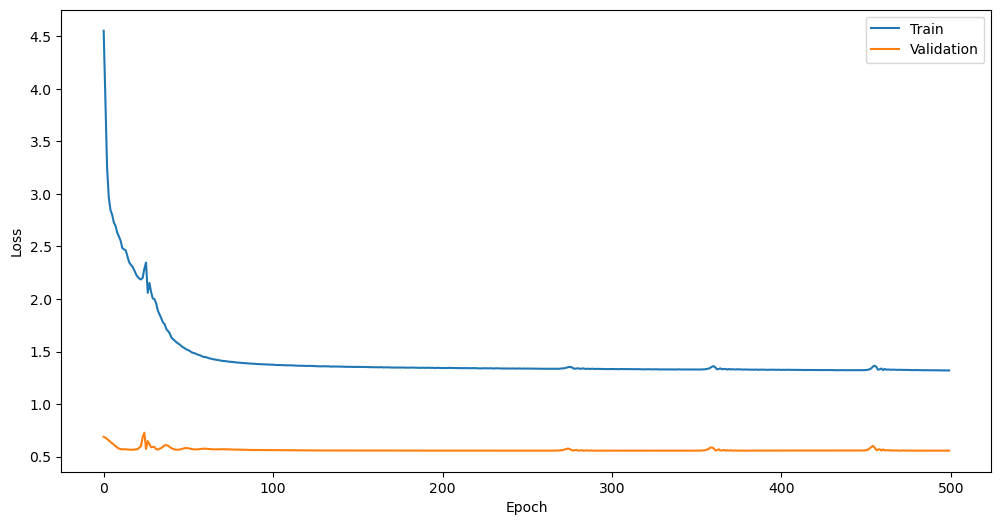

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Validation loss is lower than Train loss because of 'Dropout' layer.

# Predict Test set

Use the whole train set(Train + Validation above).

In [39]:
# Scaling
scaler = MinMaxScaler()

X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [ ]:
# To Tensor
X_train_val = torch.FloatTensor(X_train_val).to(device)
X_test = torch.FloatTensor(X_test).to(device)

y_train_val = torch.LongTensor(y_train_val.values).to(device)
y_test = torch.LongTensor(y_test.values).to(device)

In [33]:
model = Net().to(device)

# Optimizer and Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Train
for epoch in range(1, n_epochs+1):
    model.train()
    H = model(X_train)
    loss = loss_fn(H, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = (torch.argmax(H, dim=1) == y_train).float().mean().item()
        
    if epoch % 50 == 0:
        print('Epoch {:4d} / {}, Cost : {:.4f}, Acc : {:.2f} %'.format(
            epoch, n_epochs, loss.item(), acc*100))

In [ ]:
# Predict Test set
model.eval()
with torch.no_grad():
    pred = model(X_test)

Let's check Test loss and Test accuracy.

In [ ]:
test_loss = loss_fn(pred, y_test)
test_acc = (torch.argmax(pred, dim=1) == y_test).float().mean().item()

print('Test Loss : {:.4f}'.format(test_loss))
print('Test Accuacy : {:.2f} %'.format(test_acc*100))

### Please **Upvote** if you like my notebook!
### Thank you!

In [6]:
import utils
model = utils.Predictor().to(device)
data_type = 'random'

def train_predictor(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, n_epochs=500, save_best=False):
    acc_train,loss_train, acc_val, loss_val = [], [], [], []
    best_loss = 1000
    for epoch in range(n_epochs):
        model.train()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
        acc_train.append((torch.argmax(y_pred, dim=1) == y_train).float().mean().item())
        with torch.no_grad():
            model.eval()
            y_pred = model(X_val)
            loss = loss_fn(y_pred, y_val)
            loss_val.append(loss.item())
            acc_val.append((torch.argmax(y_pred, dim=1) == y_val).float().mean().item())
        
        if epoch % 50 == 0 or epoch==0:
            print(f'Epoch: {epoch}, Train Loss: {loss_train[-1]}, Train Accuracy: {acc_train[-1]}, Val Loss: {loss_val[-1]}, Val Accuracy: {acc_val[-1]}')
    
        if save_best and loss_val[-1] < best_loss:
            best_loss = loss_val[-1]
            model_best = model

    if save_best:
        return model_best, loss_train, loss_val, acc_train, acc_val
    else:
        return model, loss_train, loss_val, acc_train, acc_val

    # load data
X_train, y_train, X_val, y_val, X_test, y_test, num_examples, scaler = utils.load_data(
        client_id=str(1),device=device, type=data_type)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model, loss_train, loss_val, acc_train, acc_val = train_predictor(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, n_epochs=500, save_best=False)


Epoch: 0, Train Loss: 0.6937134861946106, Train Accuracy: 0.5026990175247192, Val Loss: 0.6953420639038086, Val Accuracy: 0.479404479265213
Epoch: 50, Train Loss: 0.685705840587616, Train Accuracy: 0.6979587078094482, Val Loss: 0.6860567927360535, Val Accuracy: 0.6861042380332947
Epoch: 100, Train Loss: 0.6577197313308716, Train Accuracy: 0.7199851274490356, Val Loss: 0.6584335565567017, Val Accuracy: 0.70322585105896
Epoch: 150, Train Loss: 0.5613138675689697, Train Accuracy: 0.7229633331298828, Val Loss: 0.5715151429176331, Val Accuracy: 0.707196056842804
Epoch: 200, Train Loss: 0.5345183610916138, Train Accuracy: 0.7343178391456604, Val Loss: 0.5535317659378052, Val Accuracy: 0.7178660035133362
Epoch: 250, Train Loss: 0.5245149731636047, Train Accuracy: 0.742011547088623, Val Loss: 0.5454826354980469, Val Accuracy: 0.7220844030380249
Epoch: 300, Train Loss: 0.5182069540023804, Train Accuracy: 0.7458584308624268, Val Loss: 0.539808452129364, Val Accuracy: 0.7267990112304688
Epoch: 35

In [11]:
# import utils   
# data_type = "random" 
# # check device
# device = utils.check_gpu(manual_seed=True, print_info=False)

# # load data
df_test = pd.read_csv("data/df_test_"+data_type+".csv")
df_test = df_test.astype(int)
# # Dataset split
X = df_test.drop('Diabetes_binary', axis=1)
y = df_test['Diabetes_binary']

# # scale data
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X.values)
X_test = X.values
X_test = torch.Tensor(X_test).float().to(device)
y_test = torch.LongTensor(y.values).to(device)

#X_test = scaler.transform(X.values)
#_test = torch.Tensor(X_test).float().to(device)
#y_test = torch.LongTensor(y.values).to(device)

# load model

#model = utils.Predictor().to(device)
#model.load_state_dict(torch.load(f"checkpoints_predictor/{data_type}/model_round_{500}.pth"))
# evaluate
model.eval()
with torch.no_grad():
    y = model(X_test)
    #y = y.argmax(dim=1).detach().cpu().numpy()
    acc = (torch.argmax(y, dim=1) == y_test).float().mean().item()
#return y, accuracy_score(y_test.cpu().numpy(), y)
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 50.78%


In [8]:
X_test

tensor([[1.0000, 1.0000, 1.0000,  ..., 0.9167, 0.6000, 0.7143],
        [1.0000, 1.0000, 1.0000,  ..., 0.5000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 0.5833, 0.6000, 1.0000],
        ...,
        [1.0000, 0.0000, 1.0000,  ..., 0.5833, 0.8000, 1.0000],
        [1.0000, 0.0000, 1.0000,  ..., 0.8333, 0.8000, 0.8571],
        [1.0000, 1.0000, 1.0000,  ..., 0.4167, 0.6000, 0.7143]],
       device='mps:0')

In [15]:
import utils   
data_type = "random" 
# check device
device = utils.check_gpu(manual_seed=True, print_info=False)

# load data
df_test = pd.read_csv("data/df_test_"+data_type+".csv")
df_test = df_test.astype(int)
# Dataset split
X = df_test.drop('Diabetes_binary', axis=1)
y = df_test['Diabetes_binary']
X_test.head()

AttributeError: 'Tensor' object has no attribute 'head'

In [5]:
model = utils.Predictor().to(device)
model.load_state_dict(torch.load(f"checkpoints_predictor/{data_type}/model_round_{500}.pth"))

<All keys matched successfully>

In [17]:
acc

0.5077793002128601